In [70]:
import matplotlib.pyplot as plt
import wfdb
from tensorly.decomposition import partial_tucker
from sklearn.model_selection import train_test_split
from scipy.signal import detrend
import numpy as np
from ecgdetectors import Detectors
from tqdm import tqdm
import joblib
import numpy as np
from wfdb import processing
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal as sg
import pywt
import heartpy as hp
%matplotlib inline

In [149]:
head = wfdb.rdsamp('./ptb/patient001/s0010_re')
display(head)

(array([[-0.2445, -0.229 ,  0.0155, ..., -0.0015,  0.06  , -0.009 ],
        [-0.2425, -0.2335,  0.009 , ..., -0.0015,  0.061 , -0.01  ],
        [-0.2415, -0.2345,  0.007 , ..., -0.0035,  0.0555, -0.0085],
        ...,
        [ 0.152 ,  0.2695,  0.118 , ...,  0.079 ,  0.036 ,  0.031 ],
        [ 0.136 ,  0.256 ,  0.1205, ...,  0.081 ,  0.042 ,  0.03  ],
        [ 0.135 ,  0.2585,  0.1245, ...,  0.081 ,  0.049 ,  0.029 ]]),
 {'fs': 1000,
  'sig_len': 38400,
  'n_sig': 15,
  'base_date': None,
  'base_time': None,
  'units': ['mV',
   'mV',
   'mV',
   'mV',
   'mV',
   'mV',
   'mV',
   'mV',
   'mV',
   'mV',
   'mV',
   'mV',
   'mV',
   'mV',
   'mV'],
  'sig_name': ['i',
   'ii',
   'iii',
   'avr',
   'avl',
   'avf',
   'v1',
   'v2',
   'v3',
   'v4',
   'v5',
   'v6',
   'vx',
   'vy',
   'vz'],
  'comments': ['age: 81',
   'sex: female',
   'ECG date: 01/10/1990',
   'Diagnose:',
   'Reason for admission: Myocardial infarction',
   'Acute infarction (localization): infero-lat

In [163]:
class_dict = {'Coronary Heart Disease':'CHD', 
             'Healthy control':'CON', 
             'Cardiomyopathy':'C/HF', 
             'Bundle branch block':'BBB', 
             'Dysrhythmia':'D',
             'Hypertrophy':'MHY',
             'Valvular heart disease':'VHD',
             'Myocarditis':'MYC',
             'Myocardial infarction':'CAD',
             'Heart failure (NYHA 3)':'C/HF',
             'Heart failure (NYHA 2)':'C/HF',
             'Heart failure (NYHA 4)':'C/HF'}

In [164]:
def patient_classes(folder):
    patient_class = []
    with open(folder+'RECORDS') as f:
        file_names = [x.strip() for x in f]
    for x in file_names:
        patient = x.split('/')[0]
        with open(folder+x+'.hea') as f:
            for line in f:
                if 'Reason for admission:' in line:
                    try:
                        patient_class.append((patient, class_dict[line.split(':')[-1].strip()]))
                    except:
                        pass
    return [*{*patient_class}]


In [165]:
def patient_tt_split(zip_list, train, test, classes=None):
    if classes == None:
        X, y = zip(*zip_list)
        return train_test_split(X, y, train_size=train, test_size=test, stratify=y, random_state=1)
    else:
        X, y = zip(*[x for x in zip_list if x[1] in classes])
        return train_test_split(X, y, train_size=train, test_size=test, stratify=y, random_state=1)
MICON_dict = {'Myocardial infarction':'CAD', 
             'Healthy control':'CON'}

In [166]:
def data_load_ptb(folder, patient_set):
    full_data = []
    target = []
    global error_list
    error_list = []
    with open(folder+'RECORDS') as f:
        file_names = [x.strip() for x in f]
    for file in tqdm(file_names):
        for patient in patient_set:
            if patient in file:
                raw = wfdb.rdsamp(folder+file)
                class_label = raw[1]['comments'][4].split(': ')[-1]
                try:
                    target.append(MICON_dict[class_label])
                    full_data.append(wave_processing_pad(raw[0]))
                except:
                    pass
    return np.array(full_data), target

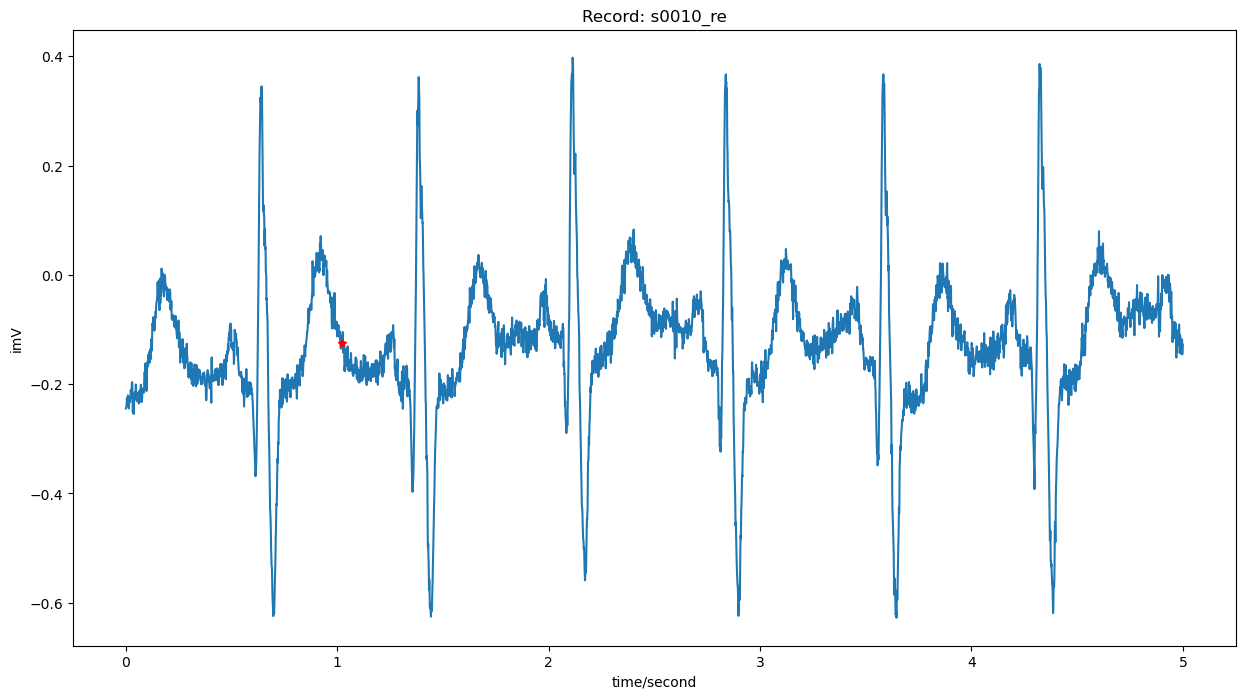

In [122]:
record = wfdb.rdrecord('./ptb/patient001/s0010_re', channels = [0],sampto=5000)
annotation = wfdb.rdann('./ptb/patient001/s0010_re', 'xyz',sampto=5000, shift_samps = True)
wfdb.plot_wfdb(record=record, annotation = annotation, time_units='seconds',figsize=(15,8))

In [123]:
def wave_processing_pad(data):
    red_channel_data = data[:,0:12]
    
    detector = Detectors(1000)
    swt_1_peaks = detector.swt_detector(detrend(red_channel_data[:,1]))[1:-1]
    swt_0_peaks = detector.swt_detector(detrend(red_channel_data[:,0]))[1:-1]
    
    if len(swt_1_peaks) > len(swt_0_peaks):
        small_list = swt_0_peaks
        long_list = swt_1_peaks
    else:
        small_list = swt_1_peaks
        long_list = swt_0_peaks
    
    diff = [swt_0_peaks[i]-swt_1_peaks[i] for i in range(len(small_list))]

    def filt_sig_proc():
        try:
            for x in range(n_channels):
                if x == 0:
                    sig = detrend(red_channel_data[slice(y-250, y+350),x])
                    if max(sig)/2 < max(sig[300:420]):
                        break
                    else:
                        ecg_vec[i,:,x] = sig
                else:
                    ecg_vec[i,:,x] = detrend(red_channel_data[slice(y-250, y+350),x])
        except:
            pass

    
    
    n_beats = 200
    n_channels = 12
    n_samples = 600
    ecg_vec = np.zeros((n_beats, n_samples, n_channels))
    for i,y in enumerate(small_list):
        if abs(diff[i]) > 20:
            for z in long_list:
                if abs(y-z) > 50:
                    pass
                else:
                    filt_sig_proc()
        else:
            filt_sig_proc()
    return ecg_vec

In [106]:
class Pan_Tompkins_QRS():
  
  def band_pass_filter(self,signal):
    '''
    Band Pass Filter
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination:
    Bandpass filter is used to attenuate the noise in the input signal.
    To acheive a passband of 5-15 Hz, the input signal is first passed 
    through a low pass filter having a cutoff frequency of 11 Hz and then
    through a high pass filter with a cutoff frequency of 5 Hz, thus
    achieving the required thresholds. 

    The low pass filter has the recursive equation:
      y(nT) = 2y(nT - T) - y(nT - 2T) + x(nT) - 2x(nT - 6T) + x(nT - 12T)

    The high pass filter has the recursive equation:
      y(nT) = 32x(nT - 16T) - y(nT - T) - x(nT) + x(nT - 32T)
    '''
    # Initialize result
    result = None
    # Create a copy of the input signal
    sig = signal.copy()
	
    # Apply the low pass filter using the equation given
    for index in range(len(signal)):
        sig[index] = signal[index]
        if (index >= 1):
            sig[index] += 2*sig[index-1]
        if (index >= 2):
            sig[index] -= sig[index-2]
        if (index >= 6):
            sig[index] -= 2*signal[index-6]
        if (index >= 12):
            sig[index] += signal[index-12] 
	
    # Copy the result of the low pass filter
    result = sig.copy()

    # Apply the high pass filter using the equation given
    for index in range(len(signal)):
        result[index] = -1*sig[index]

        if (index >= 1):
            result[index] -= result[index-1]

        if (index >= 16):
            result[index] += 32*sig[index-16]

        if (index >= 32):
            result[index] += sig[index-32]

    # Normalize the result from the high pass filter
    max_val = max(max(result),-(min(result)))
    result = result/max_val

    return result

  def derivative(self,signal):
    '''
    Derivative Filter 
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination:
    The derivative of the input signal is taken to obtain the
    information of the slope of the signal. Thus, the rate of change
    of input is obtain in this step of the algorithm.

    The derivative filter has the recursive equation:
      y(nT) = [-x(nT - 2T) - 2x(nT - T) + 2x(nT + T) + x(nT + 2T)]/(8T)
    '''

    # Initialize result
    result = signal.copy()

    # Apply the derivative filter using the equation given
    for index in range(len(signal)):
        result[index] = 0

        if (index >= 1):
            result[index] -= 2*signal[index-1]

        if (index >= 2):
            result[index] -= signal[index-2]

        if (index >= 2 and index <= len(signal)-2):
            result[index] += 2*signal[index+1]

        if (index >= 2 and index <= len(signal)-3):
            result[index] += signal[index+2]

        result[index] = (result[index]*annotation.fs)/8

    return result

  def squaring(self,signal):
    '''
    Squaring the Signal
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination:
    The squaring process is used to intensify the slope of the
    frequency response curve obtained in the derivative step. This
    step helps in restricting false positives which may be caused
    by T waves in the input signal.

    The squaring filter has the recursive equation:
      y(nT) = [x(nT)]^2
    '''

    # Initialize result
    result = signal.copy()

    # Apply the squaring using the equation given
    for index in range(len(signal)):
        result[index] = signal[index]**2

    return result    

  def moving_window_integration(self,signal):
    '''
    Moving Window Integrator
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination:
    The moving window integration process is done to obtain
    information about both the slope and width of the QRS complex.
    A window size of 0.15*(sample frequency) is used for more
    accurate results.

    The moving window integration has the recursive equation:
      y(nT) = [y(nT - (N-1)T) + x(nT - (N-2)T) + ... + x(nT)]/N

      where N is the number of samples in the width of integration
      window.
    '''

    # Initialize result and window size for integration
    result = signal.copy()
    win_size = round(0.150 * annotation.fs)
    sum = 0

    # Calculate the sum for the first N terms
    for j in range(win_size):
        sum += signal[j]/win_size
        result[j] = sum
    
    # Apply the moving window integration using the equation given
    for index in range(win_size,len(signal)):  
        sum += signal[index]/win_size
        sum -= signal[index-win_size]/win_size
        result[index] = sum

    return result

  def solve(self,signal):
    '''
    Solver, Combines all the above functions
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination:
    The peak detection algorithm works on the moving window and bandpass
    filtered signal. So the input signal is first bandpassed, then the
    output of the bandpass filter is given to the derivative function and
    the result is squared. Finally the output of the squaring function
    is given to the moving window integration function and returned. 
    '''

    # Convert the input signal into numpy array
    input_signal = signal.iloc[:,1].to_numpy()

    # Bandpass Filter
    global bpass
    bpass = self.band_pass_filter(input_signal.copy())

    # Derivative Function
    global der
    der = self.derivative(bpass.copy())

    # Squaring Function
    global sqr
    sqr = self.squaring(der.copy())

    # Moving Window Integration Function
    global mwin
    mwin = self.moving_window_integration(sqr.copy())

    return mwin

QRS_detector = Pan_Tompkins_QRS()
ecg = pd.DataFrame(np.array([list(range(len(record.adc()))),record.adc()[:,0]]).T,columns=['TimeStamp','ecg'])
output_singal = QRS_detector.solve(ecg)

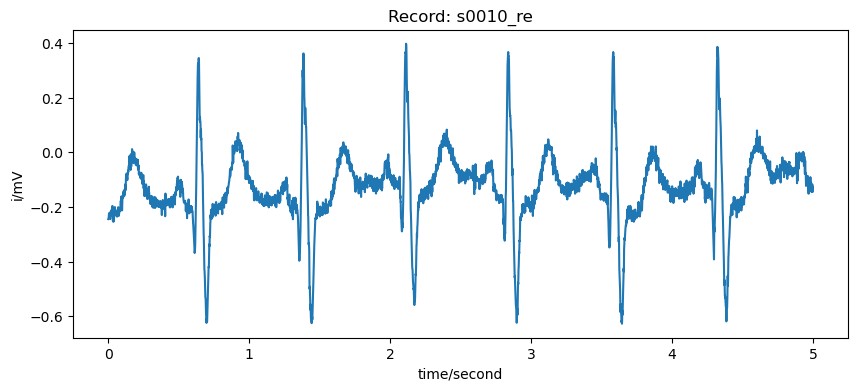

Text(0.5, 1.0, 'Moving Window Integrated Signal')

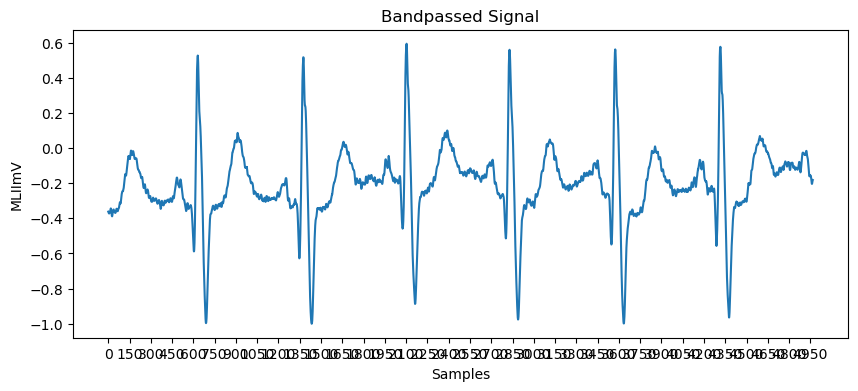

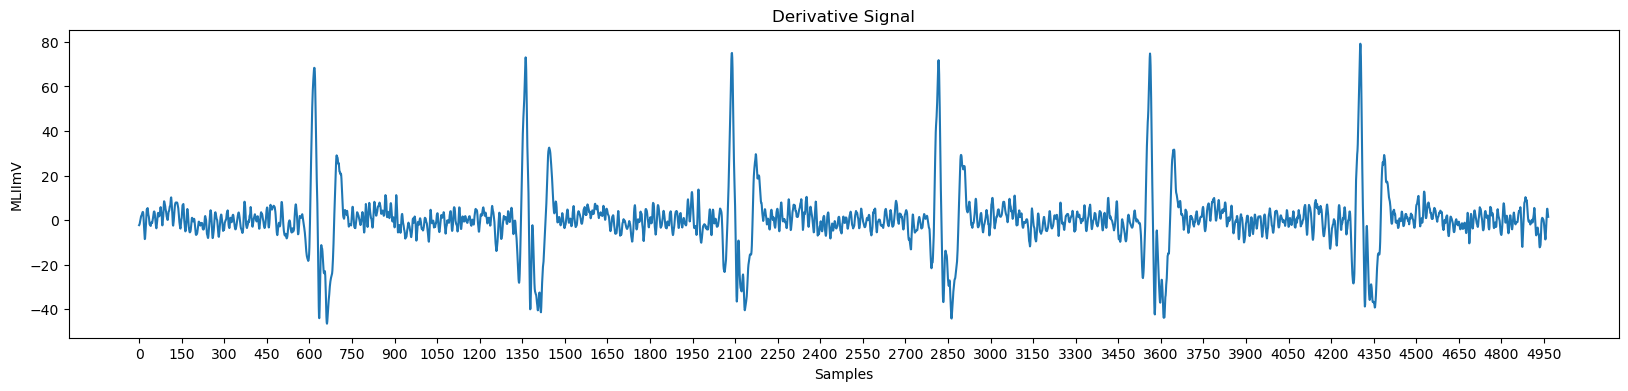

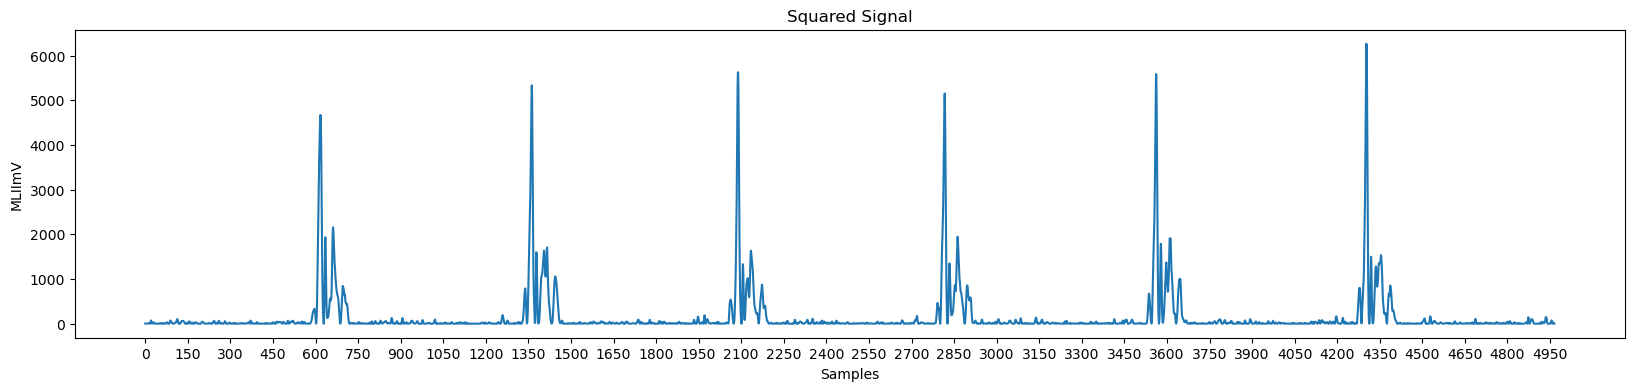

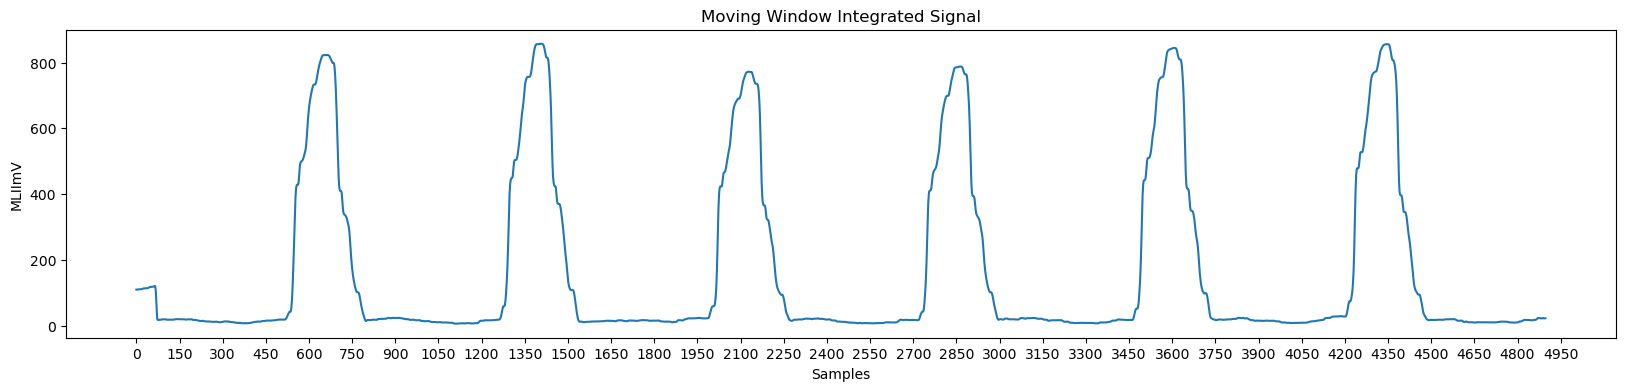

In [107]:
wfdb.plot_wfdb(record, time_units='seconds',figsize=(10,4))

plt.figure(figsize = (10,4))
plt.xticks(np.arange(0, len(bpass)+1, 150))
plt.plot(bpass[30:len(bpass)-2])
plt.xlabel('Samples')
plt.ylabel('MLIImV')
plt.title("Bandpassed Signal")

plt.figure(figsize = (20,4), dpi = 100)
plt.xticks(np.arange(0, len(der)+1, 150))
plt.plot(der[32:len(der)-2])
plt.xlabel('Samples')
plt.ylabel('MLIImV')
plt.title("Derivative Signal")

# Plotting squared signal
plt.figure(figsize = (20,4), dpi = 100)
plt.xticks(np.arange(0, len(sqr)+1, 150))
plt.plot(sqr[32:len(sqr)-2])
plt.xlabel('Samples')
plt.ylabel('MLIImV')
plt.title("Squared Signal")

# Plotting moving window integrated signal
plt.figure(figsize = (20,4), dpi = 100)
plt.xticks(np.arange(0, len(mwin)+1, 150))
plt.plot(mwin[100:len(mwin)-2])
plt.xlabel('Samples')
plt.ylabel('MLIImV')
plt.title("Moving Window Integrated Signal")

In [108]:
class heart_rate():
    def __init__(self,signal,samp_freq):
        '''
        Initialize Variables
        :param signal: input signal
        :param samp_freq: sample frequency of input signal
        '''

        # Initialize variables
        self.RR1, self.RR2, self.probable_peaks, self.r_locs, self.peaks, self.result = ([] for i in range(6))
        self.SPKI, self.NPKI, self.Threshold_I1, self.Threshold_I2, self.SPKF, self.NPKF, self.Threshold_F1, self.Threshold_F2 = (0 for i in range(8))

        self.T_wave = False          
        self.m_win = mwin
        self.b_pass = bpass
        self.samp_freq = samp_freq
        self.signal = signal
        self.win_150ms = round(0.15*self.samp_freq)

        self.RR_Low_Limit = 0
        self.RR_High_Limit = 0
        self.RR_Missed_Limit = 0
        self.RR_Average1 = 0


    def approx_peak(self):
        '''
        Approximate peak locations
        '''   

        # FFT convolution
        slopes = sg.fftconvolve(self.m_win, np.full((25,), 1) / 25, mode='same')

        # Finding approximate peak locations
        for i in range(round(0.5*self.samp_freq) + 1,len(slopes)-1):
            if (slopes[i] > slopes[i-1]) and (slopes[i+1] < slopes[i]):
                self.peaks.append(i)  


    def adjust_rr_interval(self,ind):
        '''
        Adjust RR Interval and Limits
        :param ind: current index in peaks array
        '''

        # Finding the eight most recent RR intervals
        self.RR1 = np.diff(self.peaks[max(0,ind - 8) : ind + 1])/self.samp_freq   

        # Calculating RR Averages
        self.RR_Average1 = np.mean(self.RR1)
        RR_Average2 = self.RR_Average1

        # Finding the eight most recent RR intervals lying between RR Low Limit and RR High Limit  
        if (ind >= 8):
            for i in range(0, 8):
                if (self.RR_Low_Limit < self.RR1[i] < self.RR_High_Limit): 
                    self.RR2.append(self.RR1[i])

                    if (len(self.RR2) > 8):
                        self.RR2.remove(self.RR2[0])
                        RR_Average2 = np.mean(self.RR2)    

        # Adjusting the RR Low Limit and RR High Limit
        if (len(self.RR2) > 7 or ind < 8):
            self.RR_Low_Limit = 0.92 * RR_Average2        
            self.RR_High_Limit = 1.16 * RR_Average2
            self.RR_Missed_Limit = 1.66 * RR_Average2


    def searchback(self,peak_val,RRn,sb_win):
        
        '''
        Searchback
        :param peak_val: peak location in consideration
        :param RRn: the most recent RR interval
        :param sb_win: searchback window
        '''
          # Check if the most recent RR interval is greater than the RR Missed Limit
        if (RRn > self.RR_Missed_Limit):
            
          # Initialize a window to searchback  
            win_rr = self.m_win[peak_val - sb_win + 1 : peak_val + 1] 

          # Find the x locations inside the window having y values greater than Threshold I1             
            coord = np.asarray(win_rr > self.Threshold_I1).nonzero()[0]

          # Find the x location of the max peak value in the search window
            if (len(coord) > 0):
                for pos in coord:
                    if (win_rr[pos] == max(win_rr[coord])):
                        x_max = pos
                        break
            else:
                x_max = None

          # If the max peak value is found
            if (x_max is not None):
                
            # Update the thresholds corresponding to moving window integration
                self.SPKI = 0.25 * self.m_win[x_max] + 0.75 * self.SPKI                         
                self.Threshold_I1 = self.NPKI + 0.25 * (self.SPKI - self.NPKI)
                self.Threshold_I2 = 0.5 * self.Threshold_I1         

            # Initialize a window to searchback 
                win_rr = self.b_pass[x_max - self.win_150ms: min(len(self.b_pass) -1, x_max)]  

            # Find the x locations inside the window having y values greater than Threshold F1                   
                coord = np.asarray(win_rr > self.Threshold_F1).nonzero()[0]

            # Find the x location of the max peak value in the search window
            if (len(coord) > 0):
                for pos in coord:
                    if (win_rr[pos] == max(win_rr[coord])):
                        r_max = pos
                        break
            else:
                r_max = None

            # If the max peak value is found
            if (r_max is not None):
              # Update the thresholds corresponding to bandpass filter
              if self.b_pass[r_max] > self.Threshold_F2:                                                        
                    self.SPKF = 0.25 * self.b_pass[r_max] + 0.75 * self.SPKF                            
                    self.Threshold_F1 = self.NPKF + 0.25 * (self.SPKF - self.NPKF)
                    self.Threshold_F2 = 0.5 * self.Threshold_F1      

                  # Append the probable R peak location                      
                    self.r_locs.append(r_max)                                                


    def find_t_wave(self,peak_val,RRn,ind,prev_ind):
        '''
        T Wave Identification
        :param peak_val: peak location in consideration
        :param RRn: the most recent RR interval
        :param ind: current index in peaks array
        :param prev_ind: previous index in peaks array
        '''
        if (self.m_win[peak_val] >= self.Threshold_I1):
            
            if (ind > 0 and 0.20 < RRn < 0.36):
              # Find the slope of current and last waveform detected        
                curr_slope = max(np.diff(self.m_win[peak_val - round(self.win_150ms/2) : peak_val + 1]))
                last_slope = max(np.diff(self.m_win[self.peaks[prev_ind] - round(self.win_150ms/2) : self.peaks[prev_ind] + 1]))

              # If current waveform slope is less than half of last waveform slope
                if (curr_slope < 0.5*last_slope): 
                  # T Wave is found and update noise threshold                      
                    self.T_wave = True                             
                    self.NPKI = 0.125 * self.m_win[peak_val] + 0.875 * self.NPKI 

            if (not self.T_wave):
                # T Wave is not found and update signal thresholds
                if (self.probable_peaks[ind] > self.Threshold_F1):   
                    self.SPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.SPKI                                         
                    self.SPKF = 0.125 * self.b_pass[ind] + 0.875 * self.SPKF 

                    # Append the probable R peak location
                    self.r_locs.append(self.probable_peaks[ind])  

                else:
                    self.SPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.SPKI
                    self.NPKF = 0.125 * self.b_pass[ind] + 0.875 * self.NPKF                   

        # Update noise thresholds
        elif (self.m_win[peak_val] < self.Threshold_I1) or (self.Threshold_I1 < self.m_win[peak_val] < self.Threshold_I2):
            self.NPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.NPKI  
            self.NPKF = 0.125 * self.b_pass[ind] + 0.875 * self.NPKF


    def adjust_thresholds(self,peak_val,ind):
        '''
        Adjust Noise and Signal Thresholds During Learning Phase
        :param peak_val: peak location in consideration
        :param ind: current index in peaks array
        '''
        if (self.m_win[peak_val] >= self.Threshold_I1): 
            # Update signal threshold
            self.SPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.SPKI

            if (self.probable_peaks[ind] > self.Threshold_F1):                                            
                self.SPKF = 0.125 * self.b_pass[ind] + 0.875 * self.SPKF 

                # Append the probable R peak location
                self.r_locs.append(self.probable_peaks[ind])  

            else:
                # Update noise threshold
                self.NPKF = 0.125 * self.b_pass[ind] + 0.875 * self.NPKF                                    

        # Update noise thresholds    
        elif (self.m_win[peak_val] < self.Threshold_I2) or (self.Threshold_I2 < self.m_win[peak_val] < self.Threshold_I1):
            self.NPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.NPKI  
            self.NPKF = 0.125 * self.b_pass[ind] + 0.875 * self.NPKF


    def update_thresholds(self):
        '''
        Update Noise and Signal Thresholds for next iteration
        '''

        self.Threshold_I1 = self.NPKI + 0.25 * (self.SPKI - self.NPKI)
        self.Threshold_F1 = self.NPKF + 0.25 * (self.SPKF - self.NPKF)
        self.Threshold_I2 = 0.5 * self.Threshold_I1 
        self.Threshold_F2 = 0.5 * self.Threshold_F1
        self.T_wave = False 


    def ecg_searchback(self):
        '''
        Searchback in ECG signal to increase efficiency
        '''

        # Filter the unique R peak locations
        self.r_locs = np.unique(np.array(self.r_locs).astype(int))

        # Initialize a window to searchback
        win_200ms = round(0.2*self.samp_freq)

        for r_val in self.r_locs:
            coord = np.arange(r_val - win_200ms, min(len(self.signal), r_val + win_200ms + 1), 1)
            # Find the x location of the max peak value
            if (len(coord) > 0):
                for pos in coord:
                    if (self.signal[pos] == max(self.signal[coord])):
                        x_max = pos
                        break
            else:
                x_max = None

            # Append the peak location
            if (x_max is not None):   
                self.result.append(x_max)


    def find_r_peaks(self):
        '''
        R Peak Detection
        '''
        # Find approximate peak locations
        self.approx_peak()

        # Iterate over possible peak locations
        for ind in range(len(self.peaks)):

            # Initialize the search window for peak detection
            peak_val = self.peaks[ind]
            win_300ms = np.arange(max(0, self.peaks[ind] - self.win_150ms), min(self.peaks[ind] + self.win_150ms, len(self.b_pass)-1), 1)
            max_val = max(self.b_pass[win_300ms], default = 0)

            # Find the x location of the max peak value
            if (max_val != 0):        
                x_coord = np.asarray(self.b_pass == max_val).nonzero()
                self.probable_peaks.append(x_coord[0][0])

            if (ind < len(self.probable_peaks) and ind != 0):
                # Adjust RR interval and limits 
                self.adjust_rr_interval(ind)

                # Adjust thresholds in case of irregular beats
                if (self.RR_Average1 < self.RR_Low_Limit or self.RR_Average1 > self.RR_Missed_Limit): 
                    self.Threshold_I1 /= 2
                    self.Threshold_F1 /= 2

                RRn = self.RR1[-1]

                # Searchback
                self.searchback(peak_val,RRn,round(RRn*self.samp_freq))

                # T Wave Identification
                self.find_t_wave(peak_val,RRn,ind,ind-1)

            else:
              # Adjust threholds
              self.adjust_thresholds(peak_val,ind)

            # Update threholds for next iteration
            self.update_thresholds()

        # Searchback in ECG signal 
        self.ecg_searchback()

        return self.result

[ 643 1385 2113 2838 3583 4322]
Heart Beats 81.71603677221655


Text(0.5, 1.0, 'R Peak Locations')

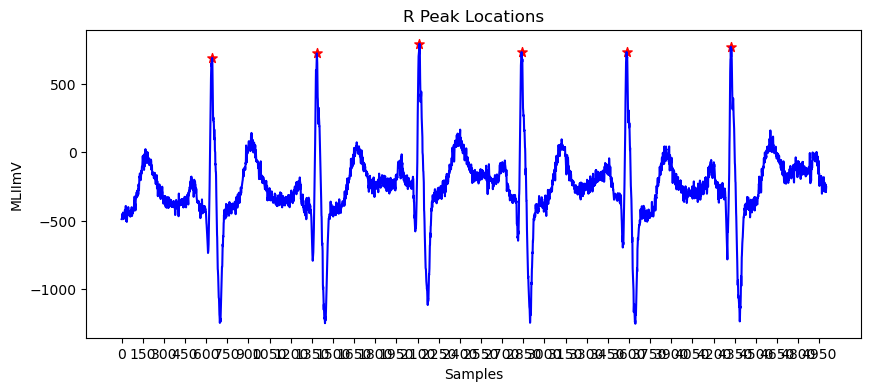

In [109]:
# Convert ecg signal to numpy array
signal = ecg.iloc[:,1].to_numpy()

# Find the R peak locations
hr = heart_rate(signal,annotation.fs)
result = hr.find_r_peaks()
result = np.array(result)
print(result)

# Clip the x locations less than 0 (Learning Phase)
result = result[result > 0]

# Calculate the heart rate
heartRate = (60*annotation.fs)/np.average(np.diff(result[1:]))
print("Heart Beats",heartRate)

# Plotting the R peak locations in ECG signal
plt.figure(figsize = (10,4), dpi = 100)
plt.xticks(np.arange(0, len(signal)+1, 150))
plt.plot(signal, color = 'blue')        
plt.scatter(result, signal[result], color = 'red', s = 50, marker= '*')
plt.xlabel('Samples')
plt.ylabel('MLIImV')
plt.title("R Peak Locations")

In [167]:
def stack_and_tensor(data):
    return tensorly.base.vec_to_tensor(np.stack(data), (len(data), *data[0].shape))

In [168]:
def train_test_tensor(X, y, train_size, test_size, random_state):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, test_size=test_size, random_state=random_state, stratify=y)
    return stack_and_tensor(X_train), stack_and_tensor(X_test), np.array(y_train), np.array(y_test)

In [169]:
def reshapeing(X, y, channels):
    mask = np.zeros((X.shape[0], X.shape[1]))
    new_y = []
    for record in range(X.shape[0]):
        for beat in range(X.shape[1]):
            if np.any(X[record,beat,:,:]):
                mask[record,beat] = 1
                new_y.append(y[record])
    
    print(len(new_y))
    print(mask.sum())
    new_X = np.zeros((len(new_y), X.shape[2], channels))
    count = 0
    for record in range(X.shape[0]):
        for beat in range(X.shape[1]):
            if mask[record,beat]:
                new_X[count,:,:channels] = X[record,beat,:,:channels]
                count += 1
    return new_X, new_y

In [170]:
patient_zip = patient_classes('./ptb/')
train_patients, test_patients, ytr , ytest = patient_tt_split(patient_zip, 0.7, 0.3, classes=['CAD', 'CON'])
X_train, y_train = data_load_ptb('./ptb2/', train_patients)

100%|█████████████████████████████████████████| 549/549 [04:40<00:00,  1.96it/s]


In [171]:
X_test, y_test = data_load_ptb('./ptb/', test_patients)

100%|█████████████████████████████████████████| 549/549 [02:03<00:00,  4.43it/s]


In [173]:
X_train_full, y_train_full = reshapeing(X_train, y_train, 12)

27413
27413.0


In [174]:
X_test_full, y_test_full = reshapeing(X_test, y_test, 12)

12704
12704.0


In [175]:
joblib.dump(X_train_full, 'full/X_train')

joblib.dump(X_test_full, 'full/X_test')

joblib.dump(y_train_full, 'full/y_train')

joblib.dump(y_test_full, 'full/y_test')

['full/y_test']

In [176]:
X_train_red, y_train_red = reshapeing(X_train, y_train, 6)

27413
27413.0


In [177]:
X_test_red, y_test_red = reshapeing(X_test, y_test, 6)

12704
12704.0


In [178]:
X_train_red.shape, X_train_full.shape

((27413, 600, 6), (27413, 600, 12))

In [179]:
joblib.dump(X_train_red, 'reduced/X_train')

joblib.dump(X_test_red, 'reduced/X_test')

joblib.dump(y_train_red, 'reduced/y_train')

joblib.dump(y_test_red, 'reduced/y_test')

['reduced/y_test']